Importing Libraries

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, LeaveOneOut
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import warnings

# # Suppress warnings
# warnings.filterwarnings("ignore")

In [83]:
# Load data set

raw_data_dir = Path('../data/raw/processed')

Training_df = pd.read_csv(raw_data_dir/'deduplicated-training-with-medical-specialty.csv')
Testing_df = pd.read_csv(raw_data_dir/'testing-with-medical-specialty.csv')

# Assign features (X) and target (Y)
X_train = Training_df.drop(columns=['prognosis', 'medical_specialty'])
y_train = Training_df['medical_specialty']

X_test = Testing_df.drop(columns=['prognosis', 'medical_specialty'])
y_test = Testing_df['medical_specialty']

# Define the ModelPipeline class
class ModelPipeline:
    def __init__(self, model_type='logistic_regression'):
        """
        Initialize the pipeline with the chosen model type.
        param model_type: 'logistic_regression' or 'random_forest'
        """
        self.model_type = model_type
        self.label_encoder = LabelEncoder()

        # Select the prediction model with default parameters
        if self.model_type == 'logistic_regression':
            self.model = LogisticRegression(max_iter=1000, C=0.1)  # Stronger regularization
        elif self.model_type == 'random_forest':
            self.model = RandomForestClassifier(
                n_estimators=50, max_depth=10, max_features='sqrt', random_state=42
            )  # Reduced complexity
        else:
            raise ValueError("Invalid model type. Choose 'logistic_regression' or 'random_forest'.")

        # Create the pipeline with feature selection
        self.pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('scaler', StandardScaler()),
            ('feature_selection', SelectKBest(score_func=f_classif, k=20)),  # Select top 20 features
            ('classifier', self.model)
        ])

    def fit(self, X_train, y_train):
        """
        Fit the pipeline to the training data.
        param X_train: Features for training
        param y_train: Target labels for training
        """
        y_train_encoded = self.label_encoder.fit_transform(y_train)
        self.pipeline.fit(X_train, y_train_encoded)

    def predict(self, X_test):
        """
        Predict using the pipeline.
        param X_test: Features for testing
        return: Predicted labels (decoded)
        """
        y_pred_encoded = self.pipeline.predict(X_test)
        return self.label_encoder.inverse_transform(y_pred_encoded)

    def score(self, X_test, y_test):
        """
        Score the pipeline using test data.
        param X_test: Features for testing
        param y_test: Target labels for testing
        return: Accuracy score
        """
        y_test_encoded = self.label_encoder.transform(y_test)
        return self.pipeline.score(X_test, y_test_encoded)


# Initialize and evaluate the Logistic Regression pipeline
pipeline_lr = ModelPipeline(model_type='logistic_regression')
pipeline_lr.fit(X_train, y_train)
lr_accuracy = pipeline_lr.score(X_test, y_test)
print("Logistic Regression Accuracy:", lr_accuracy)

# Initialize and evaluate the Random Forest pipeline
pipeline_rf = ModelPipeline(model_type='random_forest')
pipeline_rf.fit(X_train, y_train)
rf_accuracy = pipeline_rf.score(X_test, y_test)
print("Random Forest Accuracy:", rf_accuracy)

# View transformed features (X_train) after the pipeline

# Fit the pipeline
pipeline_lr.fit(X_train, y_train)

# Extract the transformed data step by step
# Step 1: After the imputer
X_imputed = pipeline_lr.pipeline.named_steps['imputer'].transform(X_train)

# Step 2: After scaling
X_scaled = pipeline_lr.pipeline.named_steps['scaler'].transform(X_imputed)

# Step 3: After feature selection
X_selected = pipeline_lr.pipeline.named_steps['feature_selection'].transform(X_scaled)

# # Print shapes to understand the transformations
# print("Original X_train shape:", X_train.shape)
# print("After imputation:", X_imputed.shape)
# print("After scaling:", X_scaled.shape)
# print("After feature selection:", X_selected.shape)

# # If you want to inspect the final transformed data:
# print("Final transformed X_train after the pipeline:")
# print(X_selected)

Logistic Regression Accuracy: 0.7380952380952381
Random Forest Accuracy: 0.7380952380952381


Logistic Regression Evaluation on Test Set:
Logistic Regression Test Accuracy: 0.7381


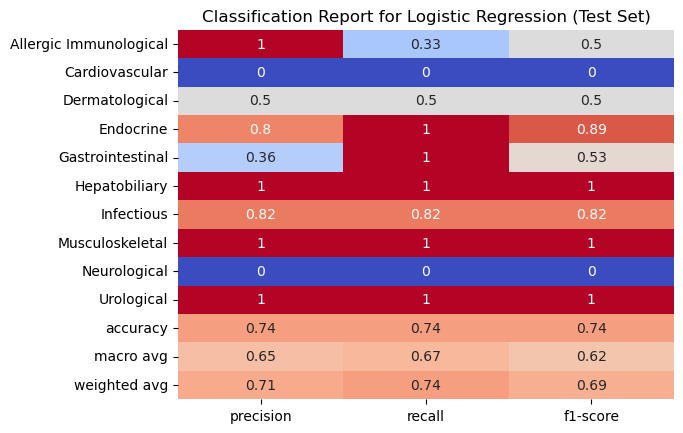

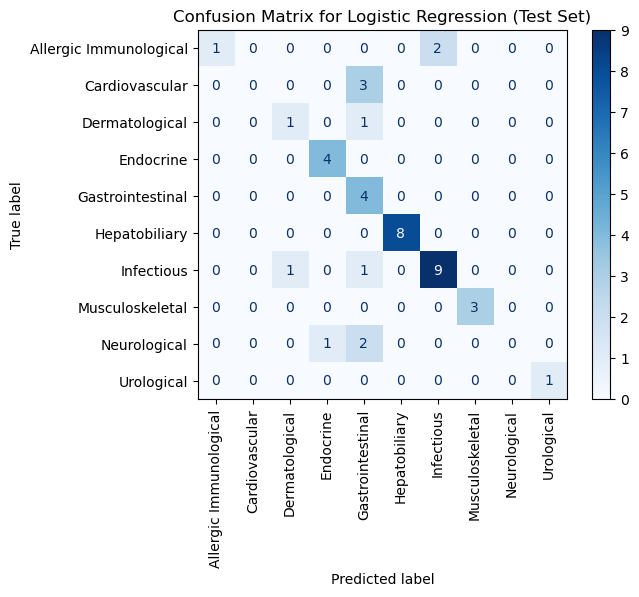

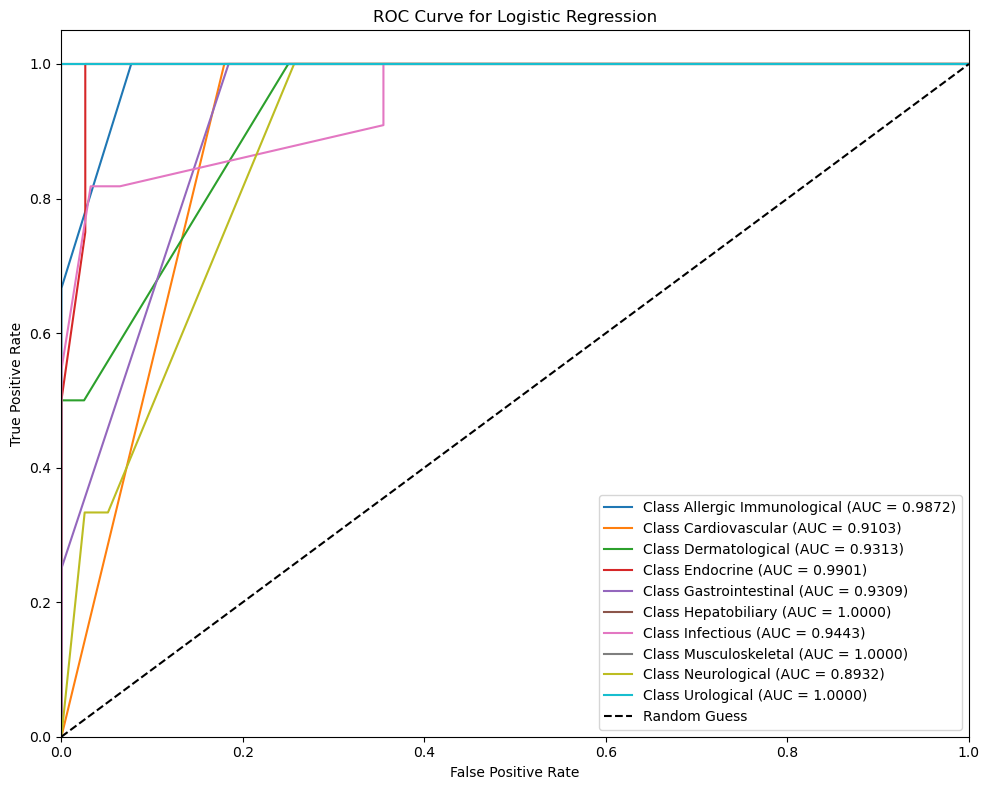

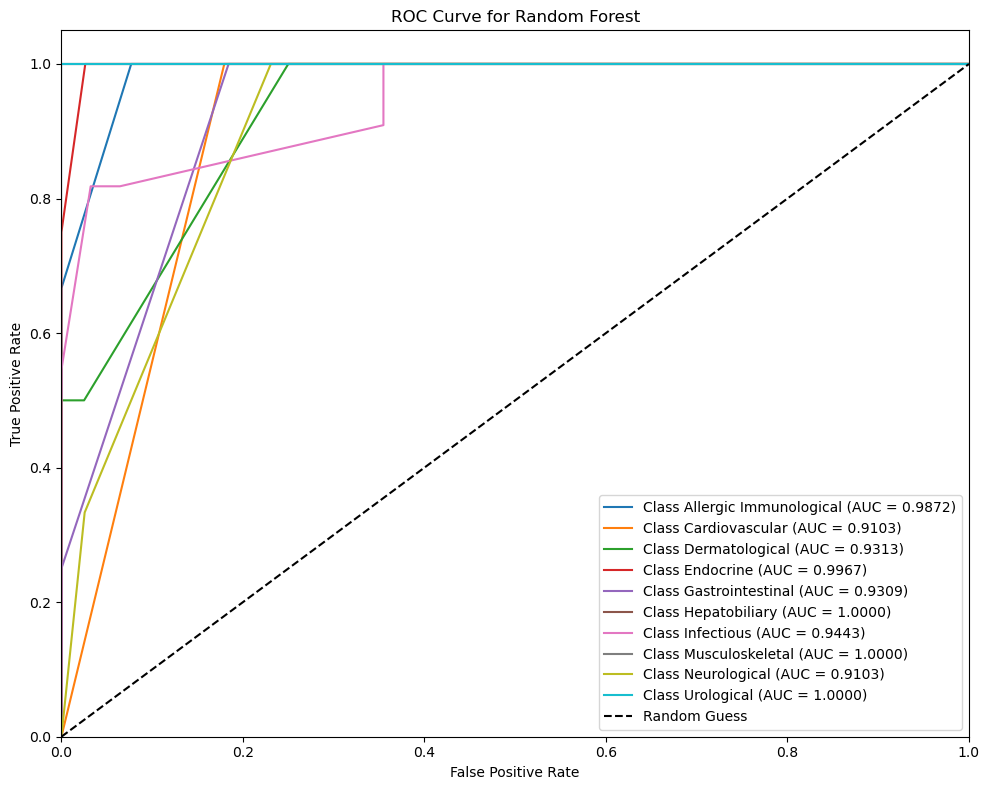


Logistic Regression LOOCV:

Logistic Regression Mean LOOCV Accuracy: 0.7730


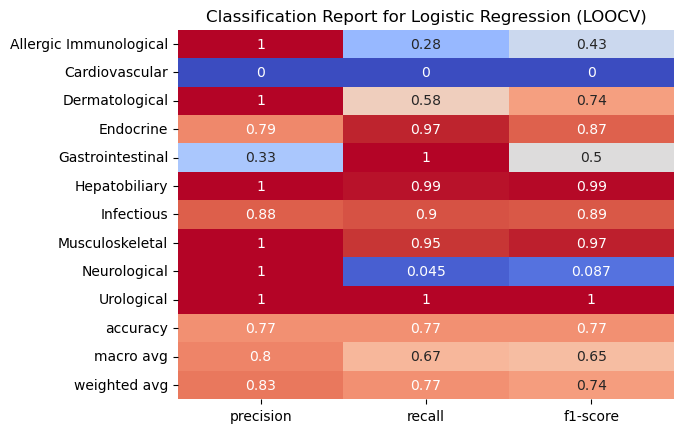

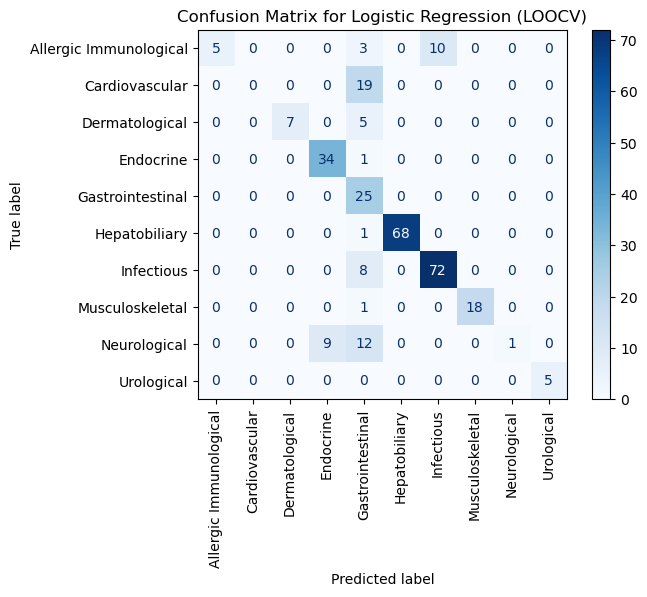


Random Forest Evaluation on Test Set:
Random Forest Test Accuracy: 0.7381


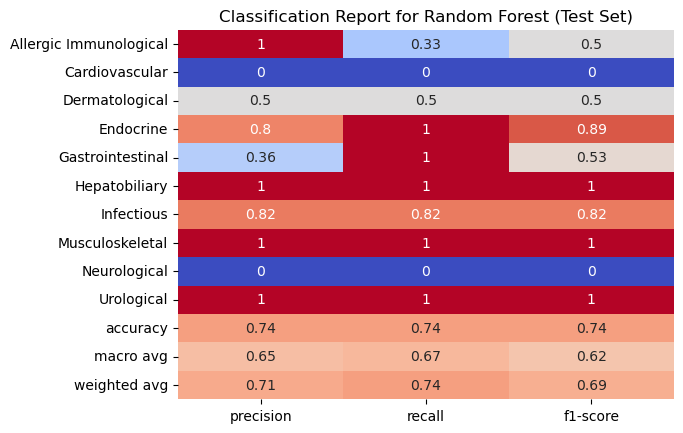

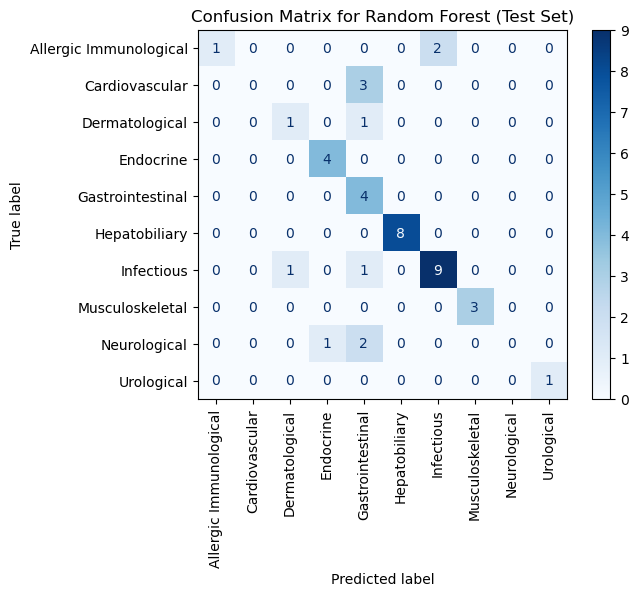


Random Forest LOOCV:

Random Forest Mean LOOCV Accuracy: 0.6974


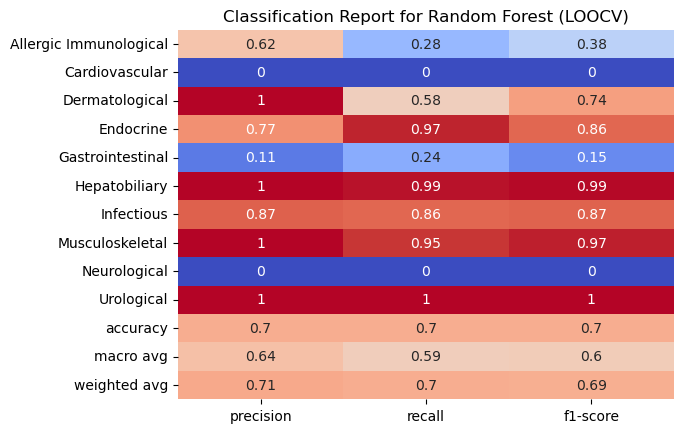

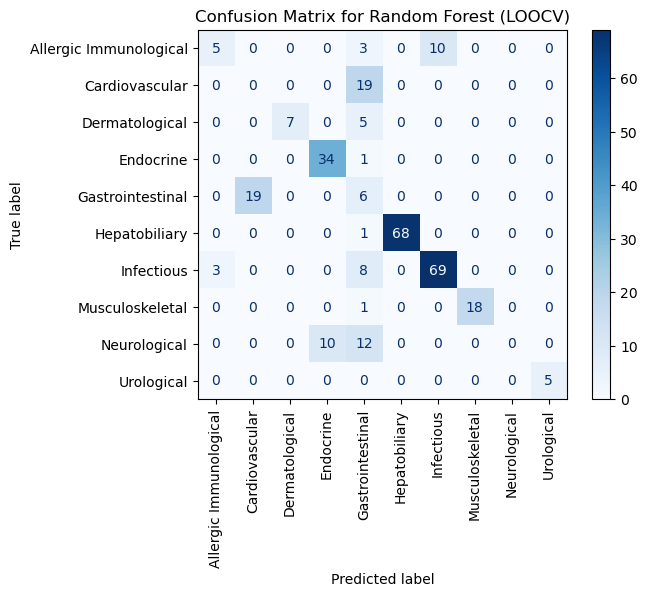

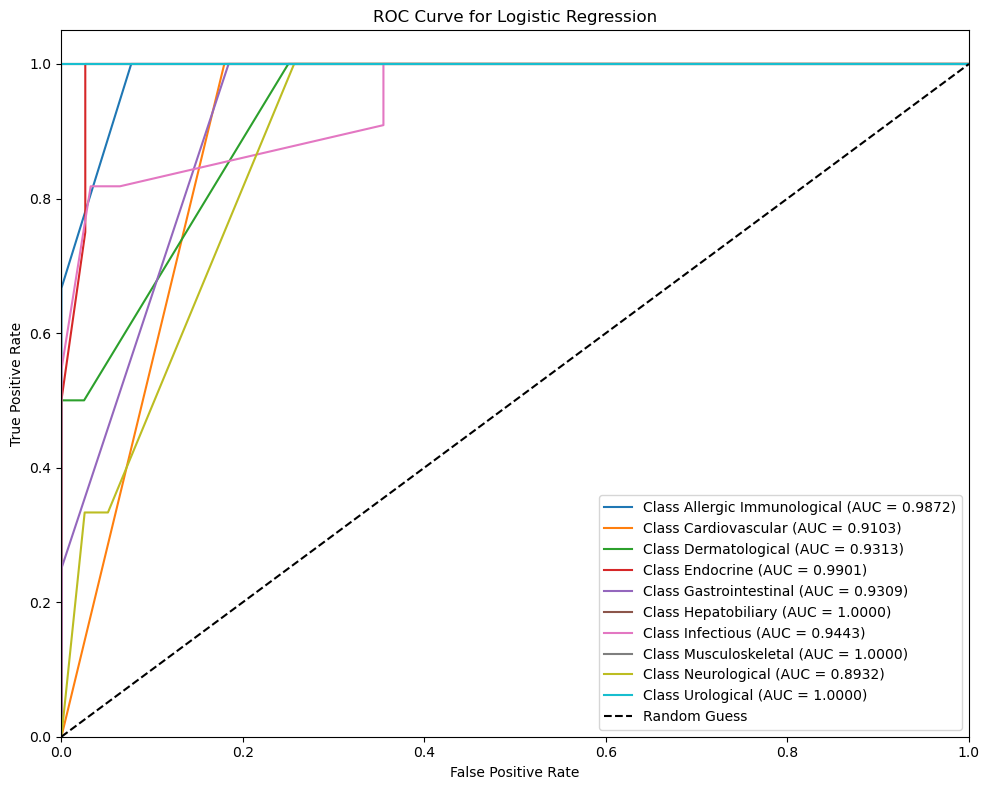

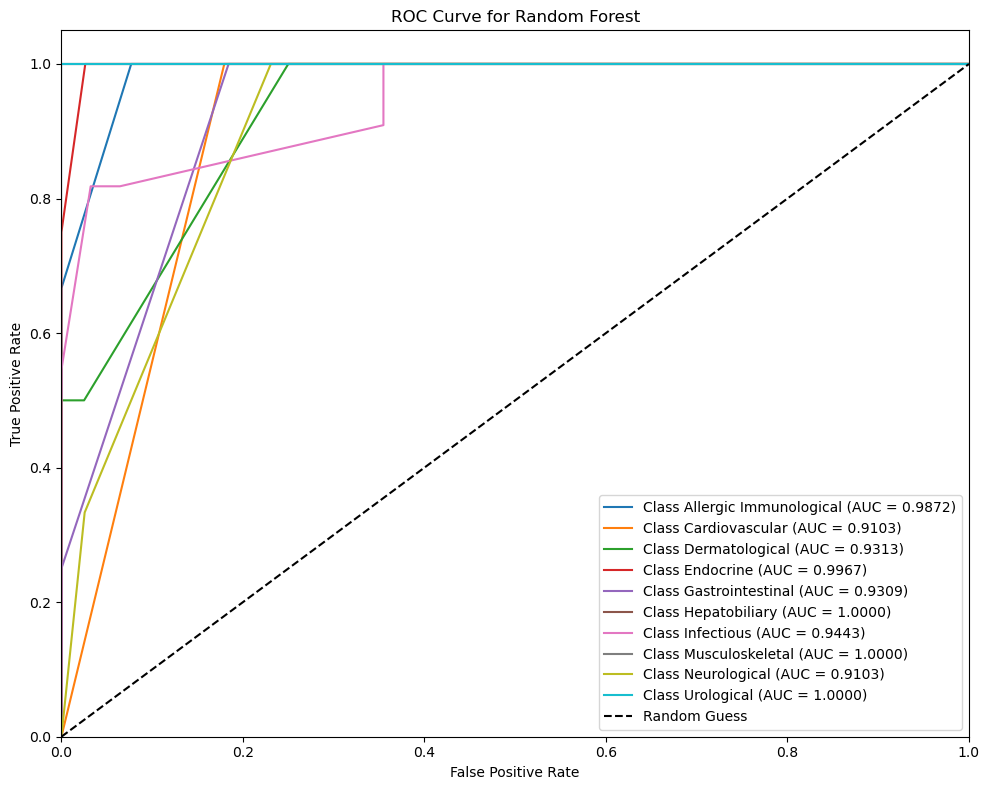

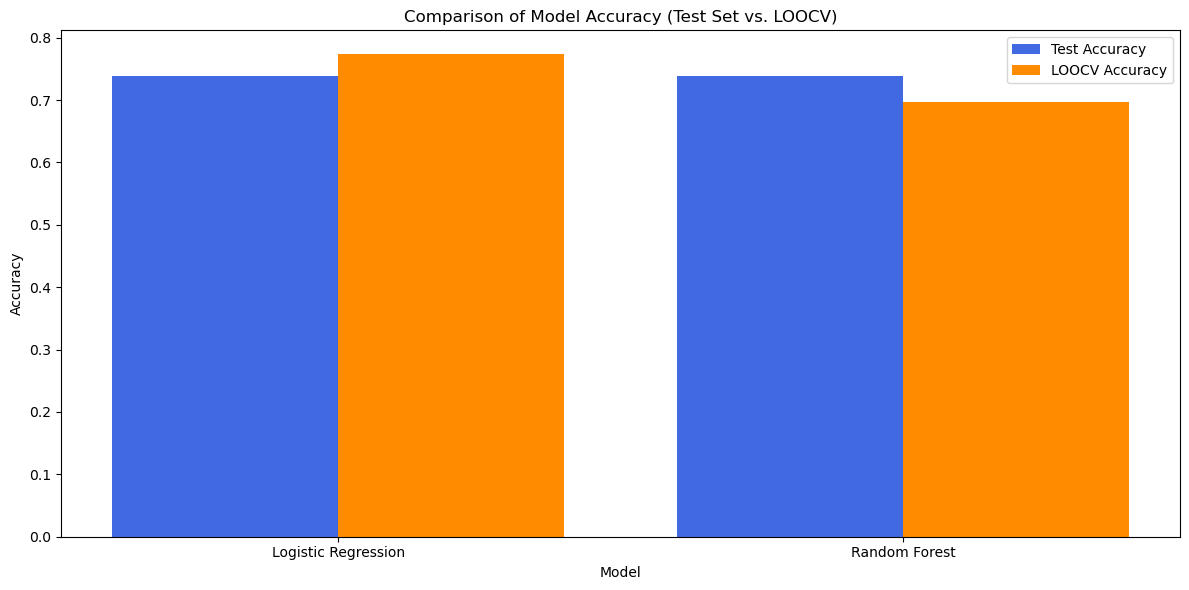

In [ ]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import LeaveOneOut

# Function to evaluate model on the test set and generate plots
def evaluate_model_with_plots(pipeline, X_test, y_test, model_name):
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name} Test Accuracy: {accuracy:.4f}")

    # Classification Report
    report = classification_report(y_test, y_pred, output_dict=True, target_names=pipeline.label_encoder.classes_)
    sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True, cmap='coolwarm', cbar=False)
    plt.title(f"Classification Report for {model_name} (Test Set)")
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.label_encoder.classes_)
    disp.plot(cmap='Blues', values_format='d')  # Plot with counts
    plt.title(f"Confusion Matrix for {model_name} (Test Set)")
    plt.xticks(rotation=90)
    plt.show()

    return accuracy

# Function to evaluate model using LOOCV and generate plots
def leave_one_out_validation_with_plots(pipeline, X, y, model_name):
    loo = LeaveOneOut()
    y_encoded = pipeline.label_encoder.fit_transform(y)
    accuracies = []
    all_true_labels = []
    all_pred_labels = []

    for train_index, test_index in loo.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[test_index]
        y_train, y_val = y_encoded[train_index], y_encoded[test_index]

        # Fit and predict
        pipeline.pipeline.fit(X_train, y_train)
        y_pred = pipeline.pipeline.predict(X_val)

        accuracies.append(accuracy_score([y_val], [y_pred]))
        all_true_labels.append(y_val[0])
        all_pred_labels.append(y_pred[0])

    mean_accuracy = np.mean(accuracies)
    print(f"\n{model_name} Mean LOOCV Accuracy: {mean_accuracy:.4f}")

    # Classification Report
    report = classification_report(all_true_labels, all_pred_labels, output_dict=True, target_names=pipeline.label_encoder.classes_)
    sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True, cmap='coolwarm', cbar=False)
    plt.title(f"Classification Report for {model_name} (LOOCV)")
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(all_true_labels, all_pred_labels)
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.label_encoder.classes_)
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f"Confusion Matrix for {model_name} (LOOCV)")
    plt.xticks(rotation=90)
    plt.show()

    return mean_accuracy

# Function to plot ROC Curve and AUC
def plot_roc_auc(pipeline, X_test, y_test, model_name):
    # Binarize the labels for multi-class
    y_encoded = pipeline.label_encoder.fit_transform(y_test)
    y_binarized = label_binarize(y_encoded, classes=np.arange(len(pipeline.label_encoder.classes_)))

    # Get probabilities for ROC curve from the underlying model
    if hasattr(pipeline.pipeline, "predict_proba"):
        y_prob = pipeline.pipeline.predict_proba(X_test)
    else:
        raise AttributeError(f"The underlying model in {model_name} does not support probability prediction.")

    # One-vs-Rest ROC Curve
    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(y_binarized.shape[1]):
        fpr[i], tpr[i], _ = roc_curve(y_binarized[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC Curve
    plt.figure(figsize=(10, 8))
    for i in range(len(pipeline.label_encoder.classes_)):
        plt.plot(fpr[i], tpr[i], label=f'Class {pipeline.label_encoder.classes_[i]} (AUC = {roc_auc[i]:.4f})')
    
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

##### LOGISTIC REGRESSION #####

# Logistic Regression Evaluation
print("Logistic Regression Evaluation on Test Set:")
lr_accuracy = evaluate_model_with_plots(pipeline_lr, X_test, y_test, "Logistic Regression")

# Plot logistic regression roc auc
plot_roc_auc(pipeline_lr, X_test, y_test, "Logistic Regression")

# Logistic Regression LOOCV
print("\nLogistic Regression LOOCV:")
lr_loocv_accuracy = leave_one_out_validation_with_plots(pipeline_lr, X_train, y_train, "Logistic Regression")


##### RANDOM FOREST #####
# Random Forest Evaluation
print("\nRandom Forest Evaluation on Test Set:")
rf_accuracy = evaluate_model_with_plots(pipeline_rf, X_test, y_test, "Random Forest")

# Random Forest LOOCV
print("\nRandom Forest LOOCV:")
rf_loocv_accuracy = leave_one_out_validation_with_plots(pipeline_rf, X_train, y_train, "Random Forest")

# Plot Random Forest roc auc
plot_roc_auc(pipeline_rf, X_test, y_test, "Random Forest")


##### ACCURACY COMPARISON #####
# --- Plot Comparison of Model Accuracies ---
plt.figure(figsize=(12, 6))
model_names = ['Logistic Regression', 'Random Forest']
test_accuracies = [lr_accuracy, rf_accuracy]
loocv_accuracies = [lr_loocv_accuracy, rf_loocv_accuracy]

x = np.arange(len(model_names))
plt.bar(x - 0.2, test_accuracies, width=0.4, label='Test Accuracy', color='royalblue')
plt.bar(x + 0.2, loocv_accuracies, width=0.4, label='LOOCV Accuracy', color='darkorange')

plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Comparison of Model Accuracy (Test Set vs. LOOCV)")
plt.xticks(x, model_names)
plt.legend()
plt.tight_layout()
plt.show()













# from sklearn.metrics import roc_curve, auc, roc_auc_score
# from sklearn.preprocessing import label_binarize, LabelEncoder
# from sklearn.multiclass import OneVsRestClassifier

# # Function to evaluate model and plot ROC
# def evaluate_model_with_plots(pipeline, X_test, y_test, model_name):
#     y_encoded = pipeline.label_encoder.transform(y_test)
#     y_prob = pipeline.pipeline.predict_proba(X_test)

#     # Accuracy and Loss
#     predictions = np.argmax(y_prob, axis=1)
#     test_accuracy = accuracy_score(y_encoded, predictions)
#     test_loss = log_loss(y_encoded, y_prob)
    
#     print(f"{model_name} Test Accuracy: {test_accuracy:.4f}")
#     print(f"{model_name} Test Loss: {test_loss:.4f}")
    
#     return test_accuracy

# # Function to plot ROC Curve and AUC
# def plot_roc_auc(pipeline, X_test, y_test, model_name):
#     # Binarize the labels for multi-class
#     y_encoded = pipeline.label_encoder.fit_transform(y_test)
#     y_binarized = label_binarize(y_encoded, classes=np.arange(len(pipeline.label_encoder.classes_)))

#     # Get probabilities for ROC curve from the underlying model
#     if hasattr(pipeline.pipeline, "predict_proba"):
#         y_prob = pipeline.pipeline.predict_proba(X_test)
#     else:
#         raise AttributeError(f"The underlying model in {model_name} does not support probability prediction.")

#     # One-vs-Rest ROC Curve
#     fpr = {}
#     tpr = {}
#     roc_auc = {}

#     for i in range(y_binarized.shape[1]):
#         fpr[i], tpr[i], _ = roc_curve(y_binarized[:, i], y_prob[:, i])
#         roc_auc[i] = auc(fpr[i], tpr[i])

#     # Plot ROC Curve
#     plt.figure(figsize=(10, 8))
#     for i in range(len(pipeline.label_encoder.classes_)):
#         plt.plot(fpr[i], tpr[i], label=f'Class {pipeline.label_encoder.classes_[i]} (AUC = {roc_auc[i]:.4f})')
    
#     plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.05])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title(f'ROC Curve for {model_name}')
#     plt.legend(loc="lower right")
#     plt.tight_layout()
#     plt.show()


# # Function to perform LOOCV with loss tracking and ROC-AUC
# def leave_one_out_validation_with_plots_and_loss(pipeline, X, y, model_name):
#     loo = LeaveOneOut()
#     y_encoded = pipeline.label_encoder.fit_transform(y)
#     accuracies = []
#     losses = []
#     all_true_labels = []
#     all_pred_probs = []

#     for train_index, test_index in loo.split(X):
#         X_train, X_val = X.iloc[train_index], X.iloc[test_index]
#         y_train, y_val = y_encoded[train_index], y_encoded[test_index]

#         # Fit model and predict
#         pipeline.pipeline.fit(X_train, y_train)
#         y_pred_prob = pipeline.pipeline.predict_proba(X_val)

#         # Record accuracy and loss (log loss)
#         accuracies.append(accuracy_score([y_val], [np.argmax(y_pred_prob)]))
#         loss = -np.log(y_pred_prob[0][y_val] + 1e-9)  # Avoid log(0) with a small constant
#         losses.append(loss)

#         all_true_labels.append(y_val[0])
#         all_pred_probs.append(y_pred_prob[0])

#     # Calculate Mean Accuracy
#     mean_accuracy = np.mean(accuracies)
#     print(f"{model_name} Mean LOOCV Accuracy: {mean_accuracy:.4f}")

#     # Plot Loss over Iterations
#     plt.figure(figsize=(10, 6))
#     plt.plot(losses, label=f'{model_name} Loss')
#     plt.xlabel('Iteration')
#     plt.ylabel('Log Loss')
#     plt.title(f'Training Loss During LOOCV for {model_name}')
#     plt.legend()
#     plt.tight_layout()
#     plt.show()

#     return mean_accuracy, all_true_labels, all_pred_probs

# # Logistic Regression
# print("Logistic Regression Evaluation on Test Set:")
# lr_accuracy = evaluate_model_with_plots(pipeline_lr, X_test, y_test, "Logistic Regression")
# plot_roc_auc(pipeline_lr, X_test, y_test, "Logistic Regression")

# print("\nLogistic Regression LOOCV:")
# lr_loocv_accuracy, lr_true, lr_pred_probs = leave_one_out_validation_with_plots_and_loss(pipeline_lr, X_train, y_train, "Logistic Regression")

# # Random Forest
# print("\nRandom Forest Evaluation on Test Set:")
# rf_accuracy = evaluate_model_with_plots(pipeline_rf, X_test, y_test, "Random Forest")
# plot_roc_auc(pipeline_rf, X_test, y_test, "Random Forest")

# print("\nRandom Forest LOOCV:")
# rf_loocv_accuracy, rf_true, rf_pred_probs = leave_one_out_validation_with_plots_and_loss(pipeline_rf, X_train, y_train, "Random Forest")

# # --- Plot Comparison of Model Accuracies ---
# plt.figure(figsize=(12, 6))
# model_names = ['Logistic Regression', 'Random Forest']
# test_accuracies = [lr_accuracy, rf_accuracy]
# loocv_accuracies = [lr_loocv_accuracy, rf_loocv_accuracy]

# x = np.arange(len(model_names))
# plt.bar(x - 0.2, test_accuracies, width=0.4, label='Test Accuracy', color='royalblue')
# plt.bar(x + 0.2, loocv_accuracies, width=0.4, label='LOOCV Accuracy', color='darkorange')

# plt.xlabel("Model")
# plt.ylabel("Accuracy")
# plt.title("Comparison of Model Accuracy (Test Set vs. LOOCV)")
# plt.xticks(x, model_names)
# plt.legend()
# plt.tight_layout()
# plt.show()



Logistic Regression LOOCV with Test Loss:
Logistic Regression Mean LOOCV Accuracy: 1.0000


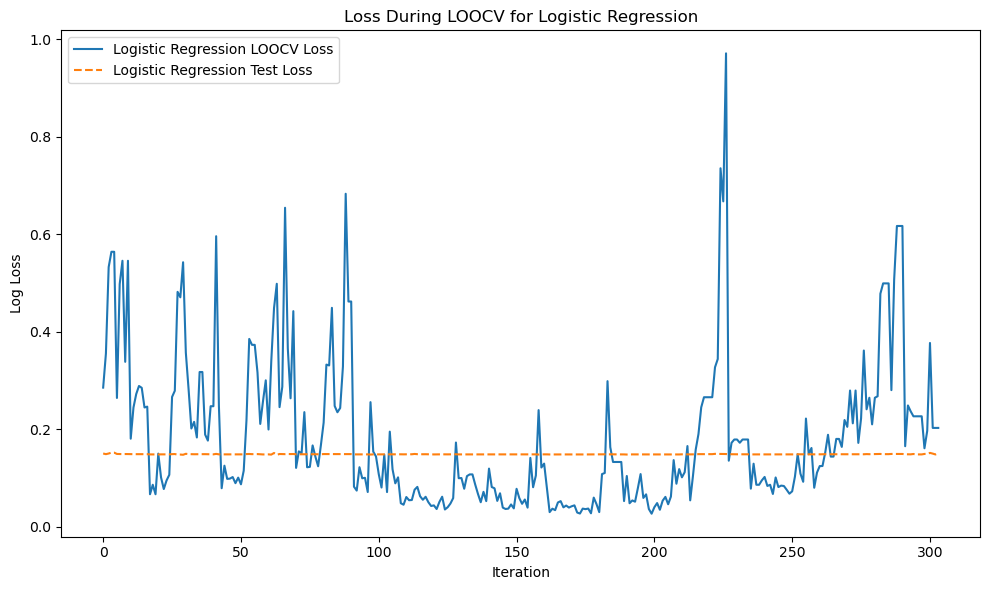


Random Forest LOOCV with Test Loss:
Random Forest Mean LOOCV Accuracy: 1.0000


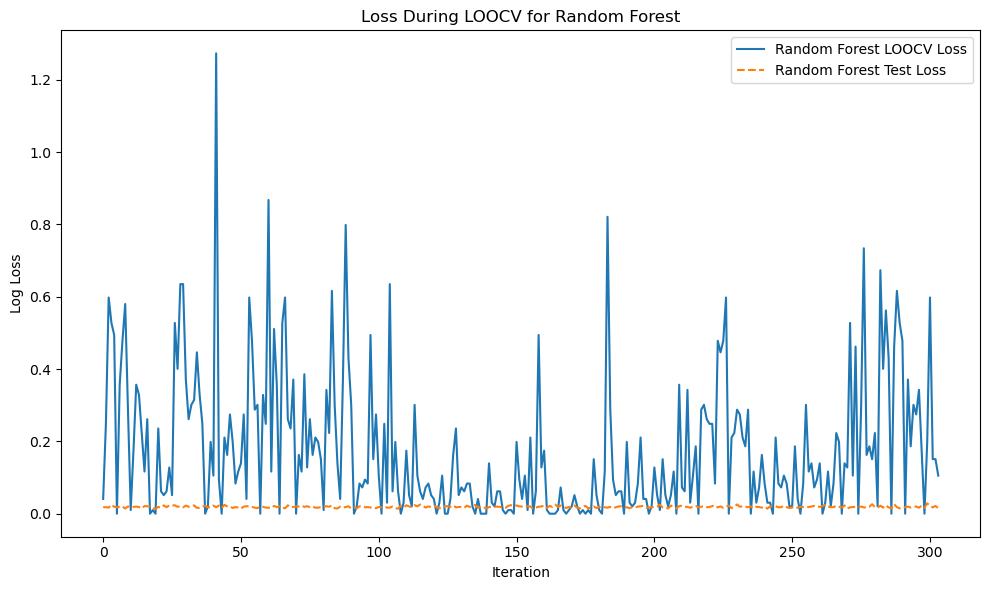

Logistic Regression Evaluation on Test Set:
Logistic Regression Test Accuracy: 1.0000
Logistic Regression Test Loss: 0.1488


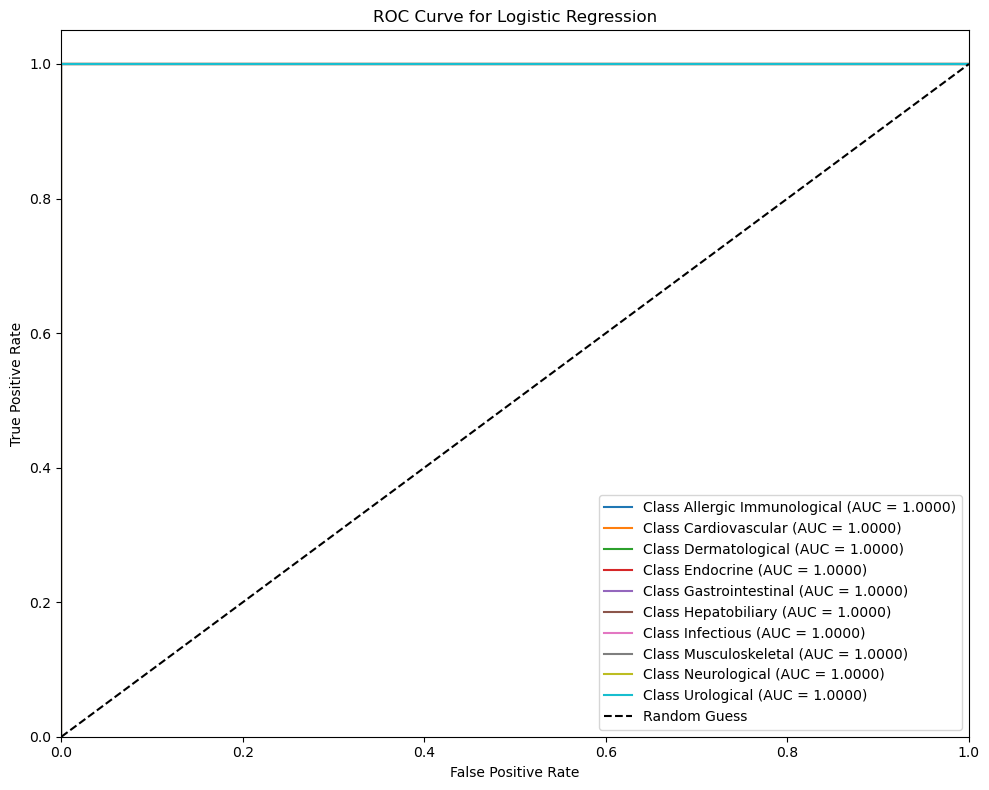


Logistic Regression LOOCV:


TypeError: leave_one_out_validation_with_loss_and_test_loss() missing 3 required positional arguments: 'y_test', 'label_encoder', and 'model_name'

In [80]:
####### TEST 2 ########

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, accuracy_score, log_loss
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import label_binarize, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from pathlib import Path

# Load Data
raw_data_dir = Path('../data/raw/processed')
Training_df = pd.read_csv(raw_data_dir / 'deduplicated-training-with-medical-specialty.csv')
Testing_df = pd.read_csv(raw_data_dir / 'testing-with-medical-specialty.csv')

# Assign Features (X) and Target (y)
X_train = Training_df.drop(columns=['prognosis', 'medical_specialty'])
y_train = Training_df['medical_specialty']
X_test = Testing_df.drop(columns=['prognosis', 'medical_specialty'])
y_test = Testing_df['medical_specialty']

# Label Encoding for target
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Define pipelines
pipeline_lr = Pipeline([('classifier', LogisticRegression(solver='lbfgs', max_iter=1000, multi_class='ovr'))])
pipeline_rf = Pipeline([('classifier', RandomForestClassifier(n_estimators=100))])

# Function to evaluate model and plot ROC
def evaluate_model_with_plots(pipeline, X_test, y_test, model_name):
    y_encoded = label_encoder.transform(y_test)
    y_prob = pipeline.predict_proba(X_test)

    # Accuracy and Loss
    predictions = np.argmax(y_prob, axis=1)
    test_accuracy = accuracy_score(y_encoded, predictions)
    test_loss = log_loss(y_encoded, y_prob)
    
    print(f"{model_name} Test Accuracy: {test_accuracy:.4f}")
    print(f"{model_name} Test Loss: {test_loss:.4f}")
    
    # ROC and AUC
    y_binarized = label_binarize(y_encoded, classes=np.arange(len(label_encoder.classes_)))
    fpr, tpr, roc_auc = {}, {}, {}

    for i in range(y_binarized.shape[1]):
        fpr[i], tpr[i], _ = roc_curve(y_binarized[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC Curve
    plt.figure(figsize=(10, 8))
    for i in range(len(label_encoder.classes_)):
        plt.plot(fpr[i], tpr[i], label=f'Class {label_encoder.classes_[i]} (AUC = {roc_auc[i]:.4f})')
    
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

    return test_accuracy

def leave_one_out_validation_with_loss_and_test_loss(pipeline, X, y, X_test, y_test, label_encoder, model_name):
    loo = LeaveOneOut()
    y_encoded = label_encoder.transform(y)
    y_test_encoded = label_encoder.transform(y_test)

    loocv_losses = []
    test_losses = []
    accuracies = []

    for train_index, val_index in loo.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y_encoded[train_index], y_encoded[val_index]

        # Fit the pipeline
        pipeline.fit(X_train, y_train)

        # Predict on LOOCV validation set
        y_val_prob = pipeline.predict_proba(X_val)
        val_loss = -np.log(y_val_prob[0][y_val] + 1e-9)  # Avoid log(0) with a small epsilon
        loocv_losses.append(val_loss)

        # Predict on the test set
        y_test_prob = pipeline.predict_proba(X_test)
        test_loss = -np.mean(np.log(y_test_prob[np.arange(len(y_test_encoded)), y_test_encoded] + 1e-9))
        test_losses.append(test_loss)

        # Accuracy for LOOCV validation
        y_val_pred = np.argmax(y_val_prob, axis=1)
        accuracies.append(accuracy_score([y_val], y_val_pred))

    # Mean accuracy
    mean_accuracy = np.mean(accuracies)
    print(f"{model_name} Mean LOOCV Accuracy: {mean_accuracy:.4f}")

    # Plot LOOCV and Test Loss
    plt.figure(figsize=(10, 6))
    plt.plot(loocv_losses, label=f'{model_name} LOOCV Loss')
    plt.plot(test_losses, label=f'{model_name} Test Loss', linestyle='--')
    plt.xlabel('Iteration')
    plt.ylabel('Log Loss')
    plt.title(f'Loss During LOOCV for {model_name}')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return mean_accuracy, loocv_losses, test_losses


# Logistic Regression LOOCV with Test Loss
print("\nLogistic Regression LOOCV with Test Loss:")
lr_loocv_accuracy, lr_loocv_losses, lr_test_losses = leave_one_out_validation_with_loss_and_test_loss(
    pipeline_lr, X_train, y_train, X_test, y_test, label_encoder, "Logistic Regression"
)

# Random Forest LOOCV with Test Loss
print("\nRandom Forest LOOCV with Test Loss:")
rf_loocv_accuracy, rf_loocv_losses, rf_test_losses = leave_one_out_validation_with_loss_and_test_loss(
    pipeline_rf, X_train, y_train, X_test, y_test, label_encoder, "Random Forest"
)

# Logistic Regression
pipeline_lr.fit(X_train, y_train_encoded)  # Fit the pipeline before evaluation
print("Logistic Regression Evaluation on Test Set:")
lr_accuracy = evaluate_model_with_plots(pipeline_lr, X_test, y_test, "Logistic Regression")

print("\nLogistic Regression LOOCV:")
lr_loocv_accuracy = leave_one_out_validation_with_loss_and_test_loss(pipeline_lr, X_train, y_train, "Logistic Regression")

# Random Forest
pipeline_rf.fit(X_train, y_train_encoded)  # Fit the pipeline before evaluation
print("\nRandom Forest Evaluation on Test Set:")
rf_accuracy = evaluate_model_with_plots(pipeline_rf, X_test, y_test, "Random Forest")

print("\nRandom Forest LOOCV:")
rf_loocv_accuracy = leave_one_out_validation_with_loss_and_test_loss(pipeline_rf, X_train, y_train, "Random Forest")


# Comparison Plot
plt.figure(figsize=(12, 6))
model_names = ['Logistic Regression', 'Random Forest']
test_accuracies = [lr_accuracy, rf_accuracy]
loocv_accuracies = [lr_loocv_accuracy, rf_loocv_accuracy]

x = np.arange(len(model_names))
plt.bar(x - 0.2, test_accuracies, width=0.4, label='Test Accuracy', color='royalblue')
plt.bar(x + 0.2, loocv_accuracies, width=0.4, label='LOOCV Accuracy', color='darkorange')

plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Comparison of Model Accuracy (Test Set vs. LOOCV)")
plt.xticks(x, model_names)
plt.legend()
plt.tight_layout()
plt.show()


Logistic Regression Evaluation on Test Set:
Logistic Regression Test Accuracy: 0.7381


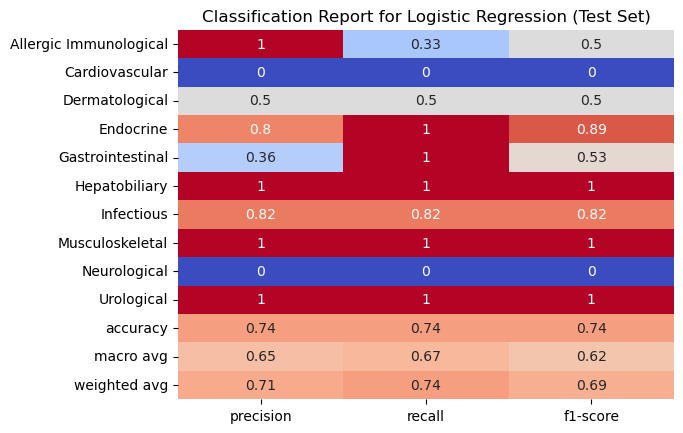

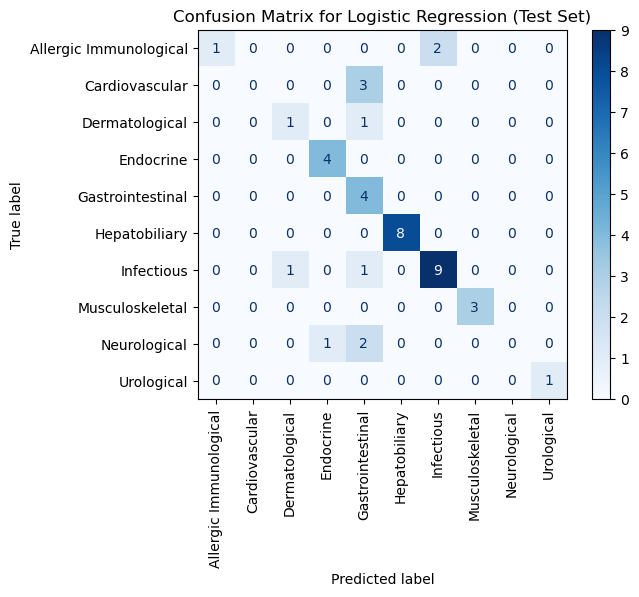


Logistic Regression LOOCV:

Logistic Regression Mean LOOCV Accuracy: 0.7730


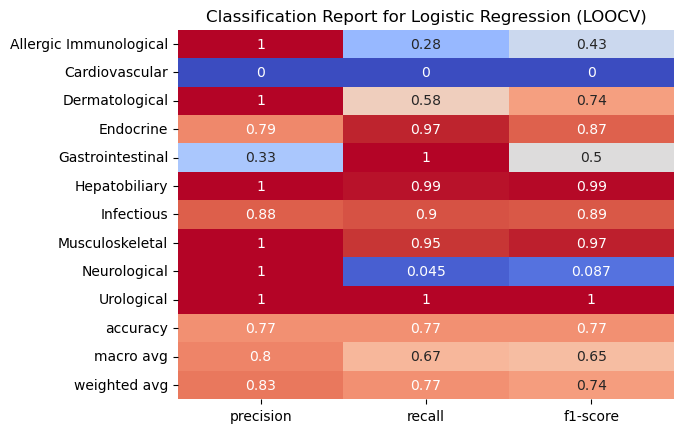

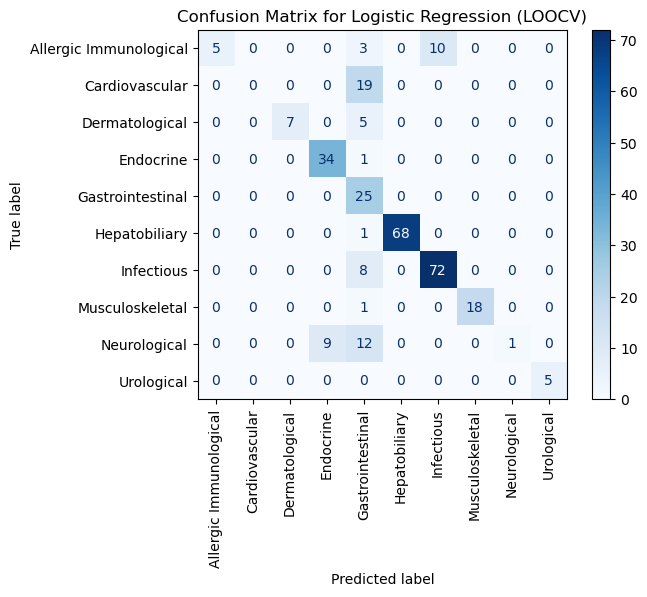


Random Forest Evaluation on Test Set:
Random Forest Test Accuracy: 0.7381


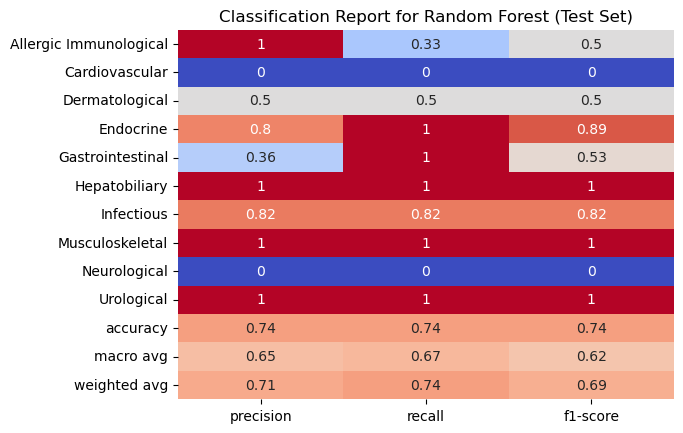

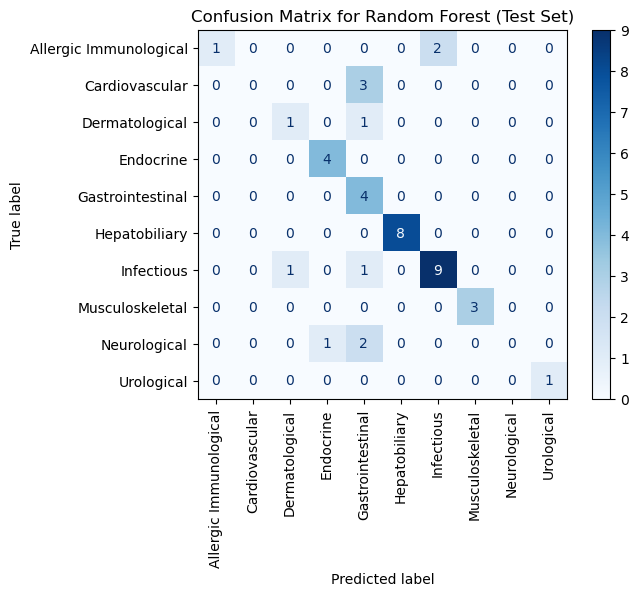


Random Forest LOOCV:

Random Forest Mean LOOCV Accuracy: 0.6974


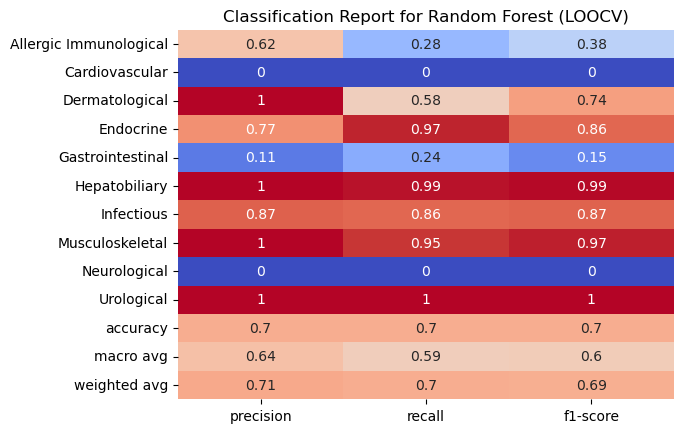

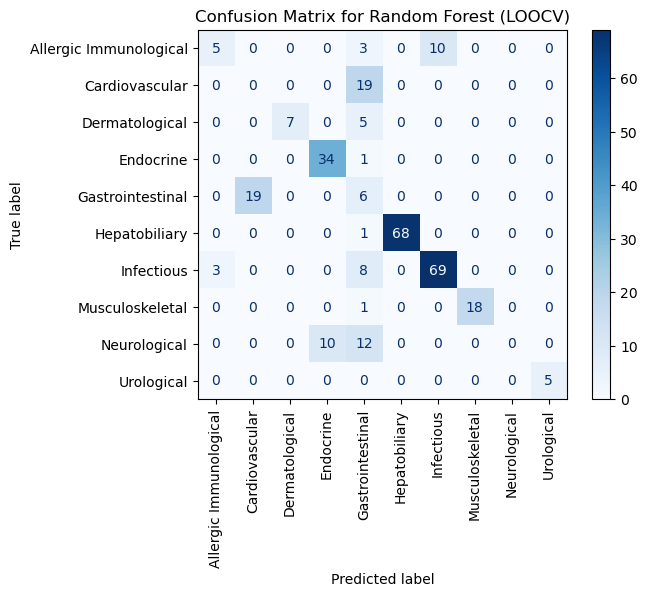

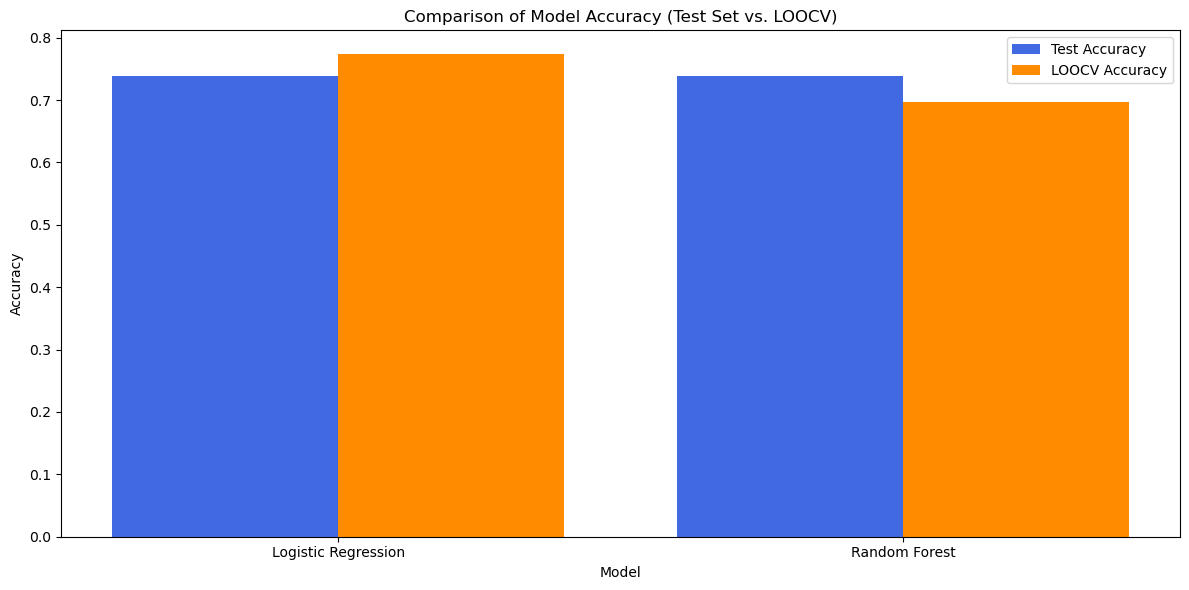

In [89]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import LeaveOneOut

# Function to evaluate model on the test set and generate plots
def evaluate_model_with_plots(pipeline, X_test, y_test, model_name):
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name} Test Accuracy: {accuracy:.4f}")

    # Classification Report
    report = classification_report(y_test, y_pred, output_dict=True, target_names=pipeline.label_encoder.classes_)
    sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True, cmap='coolwarm', cbar=False)
    plt.title(f"Classification Report for {model_name} (Test Set)")
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.label_encoder.classes_)
    disp.plot(cmap='Blues', values_format='d')  # Plot with counts
    plt.title(f"Confusion Matrix for {model_name} (Test Set)")
    plt.xticks(rotation=90)
    plt.show()

    return accuracy

# Function to evaluate model using LOOCV and generate plots
def leave_one_out_validation_with_plots(pipeline, X, y, model_name):
    loo = LeaveOneOut()
    y_encoded = pipeline.label_encoder.fit_transform(y)
    accuracies = []
    all_true_labels = []
    all_pred_labels = []

    for train_index, test_index in loo.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[test_index]
        y_train, y_val = y_encoded[train_index], y_encoded[test_index]

        # Fit and predict
        pipeline.pipeline.fit(X_train, y_train)
        y_pred = pipeline.pipeline.predict(X_val)

        accuracies.append(accuracy_score([y_val], [y_pred]))
        all_true_labels.append(y_val[0])
        all_pred_labels.append(y_pred[0])

    mean_accuracy = np.mean(accuracies)
    print(f"\n{model_name} Mean LOOCV Accuracy: {mean_accuracy:.4f}")

    # Classification Report
    report = classification_report(all_true_labels, all_pred_labels, output_dict=True, target_names=pipeline.label_encoder.classes_)
    sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True, cmap='coolwarm', cbar=False)
    plt.title(f"Classification Report for {model_name} (LOOCV)")
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(all_true_labels, all_pred_labels)
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.label_encoder.classes_)
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f"Confusion Matrix for {model_name} (LOOCV)")
    plt.xticks(rotation=90)
    plt.show()

    return mean_accuracy

# Logistic Regression Evaluation
print("Logistic Regression Evaluation on Test Set:")
lr_accuracy = evaluate_model_with_plots(pipeline_lr, X_test, y_test, "Logistic Regression")

print("\nLogistic Regression LOOCV:")
lr_loocv_accuracy = leave_one_out_validation_with_plots(pipeline_lr, X_train, y_train, "Logistic Regression")

# Random Forest Evaluation
print("\nRandom Forest Evaluation on Test Set:")
rf_accuracy = evaluate_model_with_plots(pipeline_rf, X_test, y_test, "Random Forest")

print("\nRandom Forest LOOCV:")
rf_loocv_accuracy = leave_one_out_validation_with_plots(pipeline_rf, X_train, y_train, "Random Forest")

# --- Plot Comparison of Model Accuracies ---
plt.figure(figsize=(12, 6))
model_names = ['Logistic Regression', 'Random Forest']
test_accuracies = [lr_accuracy, rf_accuracy]
loocv_accuracies = [lr_loocv_accuracy, rf_loocv_accuracy]

x = np.arange(len(model_names))
plt.bar(x - 0.2, test_accuracies, width=0.4, label='Test Accuracy', color='royalblue')
plt.bar(x + 0.2, loocv_accuracies, width=0.4, label='LOOCV Accuracy', color='darkorange')

plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Comparison of Model Accuracy (Test Set vs. LOOCV)")
plt.xticks(x, model_names)
plt.legend()
plt.tight_layout()
plt.show()
